### **1 - DQ_Learning**

In [10]:
import traci
import numpy as np

import tensorflow as tf
import pickle
import time
import matplotlib.pyplot as plt 

In [11]:
# --- Constants ---
STATE_DIM = 5
ACTION_DIM = 2  # Number of possible actions
GAMMA = 0.9  # Discount factor
ALPHA = 0.001  # Learning rate
EPSILON = 0.1  # Exploration factor
MEMORY_CAPACITY = 10000  # Replay memory size
BATCH_SIZE = 32  # Batch size for training
NUM_EPISODES = 100  # Number of training episodes

In [12]:
# --- Q-Network ---
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(STATE_DIM,)),  # Match input size
    tf.keras.layers.Dense(ACTION_DIM, activation='linear')  # Match action size
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), loss='mse')

c:\Users\s_bou\Downloads\Project_RL\Project\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


episode 0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
9.26 1.0
4.949583266934691 0.0
5.447456150388656 0.0
1.3792310450226068 0.0
2.146768215422829 0.0
2.336312554689357 0.0
2.519051689864136 0.0
2.8187896205830234 0.0
3.7590117718306524 0.0
3.3307145709040924 0.0
4.041576587424788 0.0
4.386764847903719 0.0
4.534731948196502 0.0
3.715552751794787 0.0
4.524059387798266 1.0
4.8073370981698975 1.0
4.729904648111069 1.0
4.86035927335464 1.0
4.489486350731692 1.0
4.6977091055712155 1.0
5.021860997300188 1.0
5.107794986969525 1.0
4.6015283270871405 1.0
4.80265276002168 1.0
4.328139842028186 1.0
5.1452643405764045 0.0
4.6264639216514 1.0
4.777993998586732 1.0
4.274361716570795 2.0
4.388374468141812 1.0
3.0128219167668457 0.0
3.7114323215254044 0.0
3.3001297337385425 0.0
3.8693999082926496 0.0
4.0481760710787915 0.0
4.149046288753704 0.0
3.8404572057304502 0.0
3.8943053660643563 0.0
4.057836582129997 0.0
4.250962359807093 0.0
4.

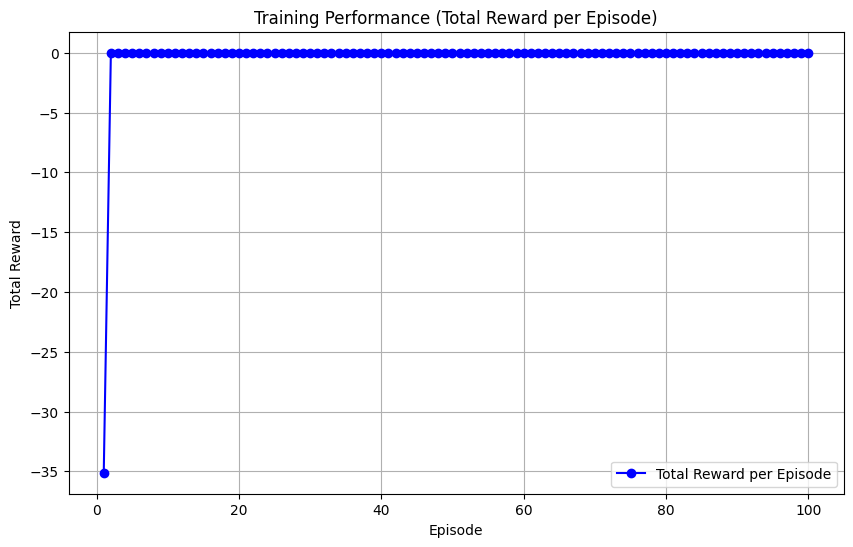

In [ ]:
# --- Replay Memory ---
memory = []

# --- Helper Functions ---
def get_state():
    """Fetch the current state from the simulator (e.g., SUMO)."""
    state = [
        traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
        traci.edge.getLastStepHaltingNumber("E4"), 
        traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0
        traci.edge.getWaitingTime("E4"),            # Waiting time in E4
        traci.edge.getWaitingTime("E5"), 
    ]
    return np.array(state)

def choose_action(state):
    """Epsilon-greedy policy to select an action."""
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        state = state.reshape(1, -1)  # Ensure the state has correct dimensions
        q_values = model.predict(state, verbose=0)[0]
        return np.argmax(q_values)

def update_q_network():
    """Update the Q-network using replay memory."""
    if len(memory) < BATCH_SIZE:
        return
    
    # Randomly sample a minibatch from memory
    indices = np.random.choice(len(memory), BATCH_SIZE, replace=False)
    minibatch = [memory[i] for i in indices]
    
    states = np.array([transition[0] for transition in minibatch])
    actions = np.array([transition[1] for transition in minibatch])
    rewards = np.array([transition[2] for transition in minibatch])
    next_states = np.array([transition[3] for transition in minibatch])
    terminals = np.array([transition[4] for transition in minibatch])
    
    q_values = model.predict(states, verbose=0)
    next_q_values = model.predict(next_states, verbose=0)
    
    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])
    
    model.fit(states, q_values, epochs=1, verbose=0)

# Reward calculation function (from your working example)
def calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed):
    """Calculate the reward based on traffic metrics."""
    # Normalize metrics
    normalized_rwt = ramp_waiting_time / max_ramp_waiting
    normalized_hf = highway_flow / max_highway_speed
    
    # Weights
    alpha = 1.0  # Weight for ramp waiting time
    beta = 1.0   # Weight for highway flow
    
    # Basic reward
    reward = -alpha * normalized_rwt + beta * normalized_hf
    
    # Penalty for extreme congestion
    if ramp_waiting_time > max_ramp_waiting * 0.8:  # Example threshold
        reward -= 10  # Strong penalty for high congestion
    
    return reward

def check_if_done():
    """Define termination condition."""
    return traci.simulation.getTime() > 1000  # Example: End after 1000 seconds

# --- Training Loop ---
traci.start(["sumo", "-c", r"sumo_config\simulation.sumocfg"])  # Update with your SUMO config file
episode_rewards = []  # To store rewards per episode

for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0
    print(f"episode {episode}")
    
    while traci.simulation.getMinExpectedNumber() > 0:
        action = choose_action(state)
        traci.trafficlight.setPhase("J7", action)  # Apply action
        traci.simulationStep()  # Step simulation
        
        next_state = get_state()
        
        # Calculate reward based on traffic metrics
        ramp_waiting_time = state[0]  # Example: ramp waiting time from state
        highway_flow = state[2]  # Example: highway flow from state
        max_ramp_waiting = 8  # Example max ramp waiting time
        max_highway_speed = 50  # Example max highway speed
        reward = calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed)
        print(highway_flow , ramp_waiting_time )
        done = check_if_done()
        
        # Store transition in replay memory
        memory.append((state, action, reward, next_state, done))
        if len(memory) > MEMORY_CAPACITY:
            memory.pop(0)
        
        update_q_network()
        state = next_state
        total_reward += reward
        
        if done:
            break
    
    episode_rewards.append(total_reward)  # Store total reward for the episode
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

# Save the trained model
model.save("q_network_model.keras")

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, label="Total Reward per Episode", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance")
plt.legend()
plt.grid(True)
plt.show()

# Close SUMO connection
traci.close()


### **Hyperparmeter-tunning:**

In [30]:
def train(EPSILON=0.1, GAMMA=0.9, ALPHA=0.001, NB_NEURONS = 32 , ACTIVATION = "relu",NUM_EPISODES=100):

    # --- Q-Network ---
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(NB_NEURONS, activation=ACTIVATION, input_shape=(STATE_DIM,)),  # Match input size
        tf.keras.layers.Dense(ACTION_DIM, activation='linear')  # Match action size
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), loss='mse')

    # --- Training Loop ---
    traci.start(["sumo", "-c", r"sumo_config\simulation.sumocfg"])  # Update with your SUMO config file
    episode_rewards = []  # To store rewards per episode

    for episode in range(NUM_EPISODES):
        state = get_state()
        total_reward = 0
        print(f"episode {episode}")
        
        while traci.simulation.getMinExpectedNumber() > 0:
            action = choose_action(state)
            traci.trafficlight.setPhase("J7", action)  # Apply action
            traci.simulationStep()  # Step simulation
            
            next_state = get_state()
            
            # Calculate reward based on traffic metrics
            ramp_waiting_time = state[0]  # Example: ramp waiting time from state
            highway_flow = state[2]  # Example: highway flow from state
            max_ramp_waiting = 8  # Example max ramp waiting time
            max_highway_speed = 50  # Example max highway speed
            reward = calculate_reward(ramp_waiting_time, highway_flow, max_ramp_waiting, max_highway_speed)
            print(highway_flow , ramp_waiting_time )
            done = check_if_done()
            
            # Store transition in replay memory
            memory.append((state, action, reward, next_state, done))
            if len(memory) > MEMORY_CAPACITY:
                memory.pop(0)
            
            update_q_network()
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        episode_rewards.append(total_reward)  # Store total reward for the episode
        print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

    traci.close()

    return episode_rewards

In [31]:
EPSILONS = [0, 1, 0.1, 0.01]
ALPHAS = [0.001,0.1, 0.2, 0.5, 0.7]
GAMMAS = [0.7, 0.9, 0.8]
ACTIVATIONS = ['relu', 'tanh', 'sigmoid']
NB_NEURONS = [32,64,128]

In [ ]:
results_epsilon = []
results_gammmas = []
results_alphas = []
results_activations = []
results_neurons = []

for EPSILON in  EPSILONS:
    result = train(EPSILON=EPSILON)
    results_epsilon.append([EPSILON, result])
for GAMMA in  GAMMAS:
    result = train(GAMMA=GAMMA)
    results_gammmas.append([GAMMA, result])
for ALPHA in  ALPHAS:
    result = train(ALPHA = ALPHA )
    results_alphas.append([ALPHA, result])
for ACTIVATION in  ACTIVATIONS:
    result = train(ACTIVATION=ACTIVATION)
    results_activations.append([ACTIVATION, result])
for neurons in  NB_NEURONS:
    result = train(NB_NEURONS=neurons)
    results_neurons.append([neurons, result])

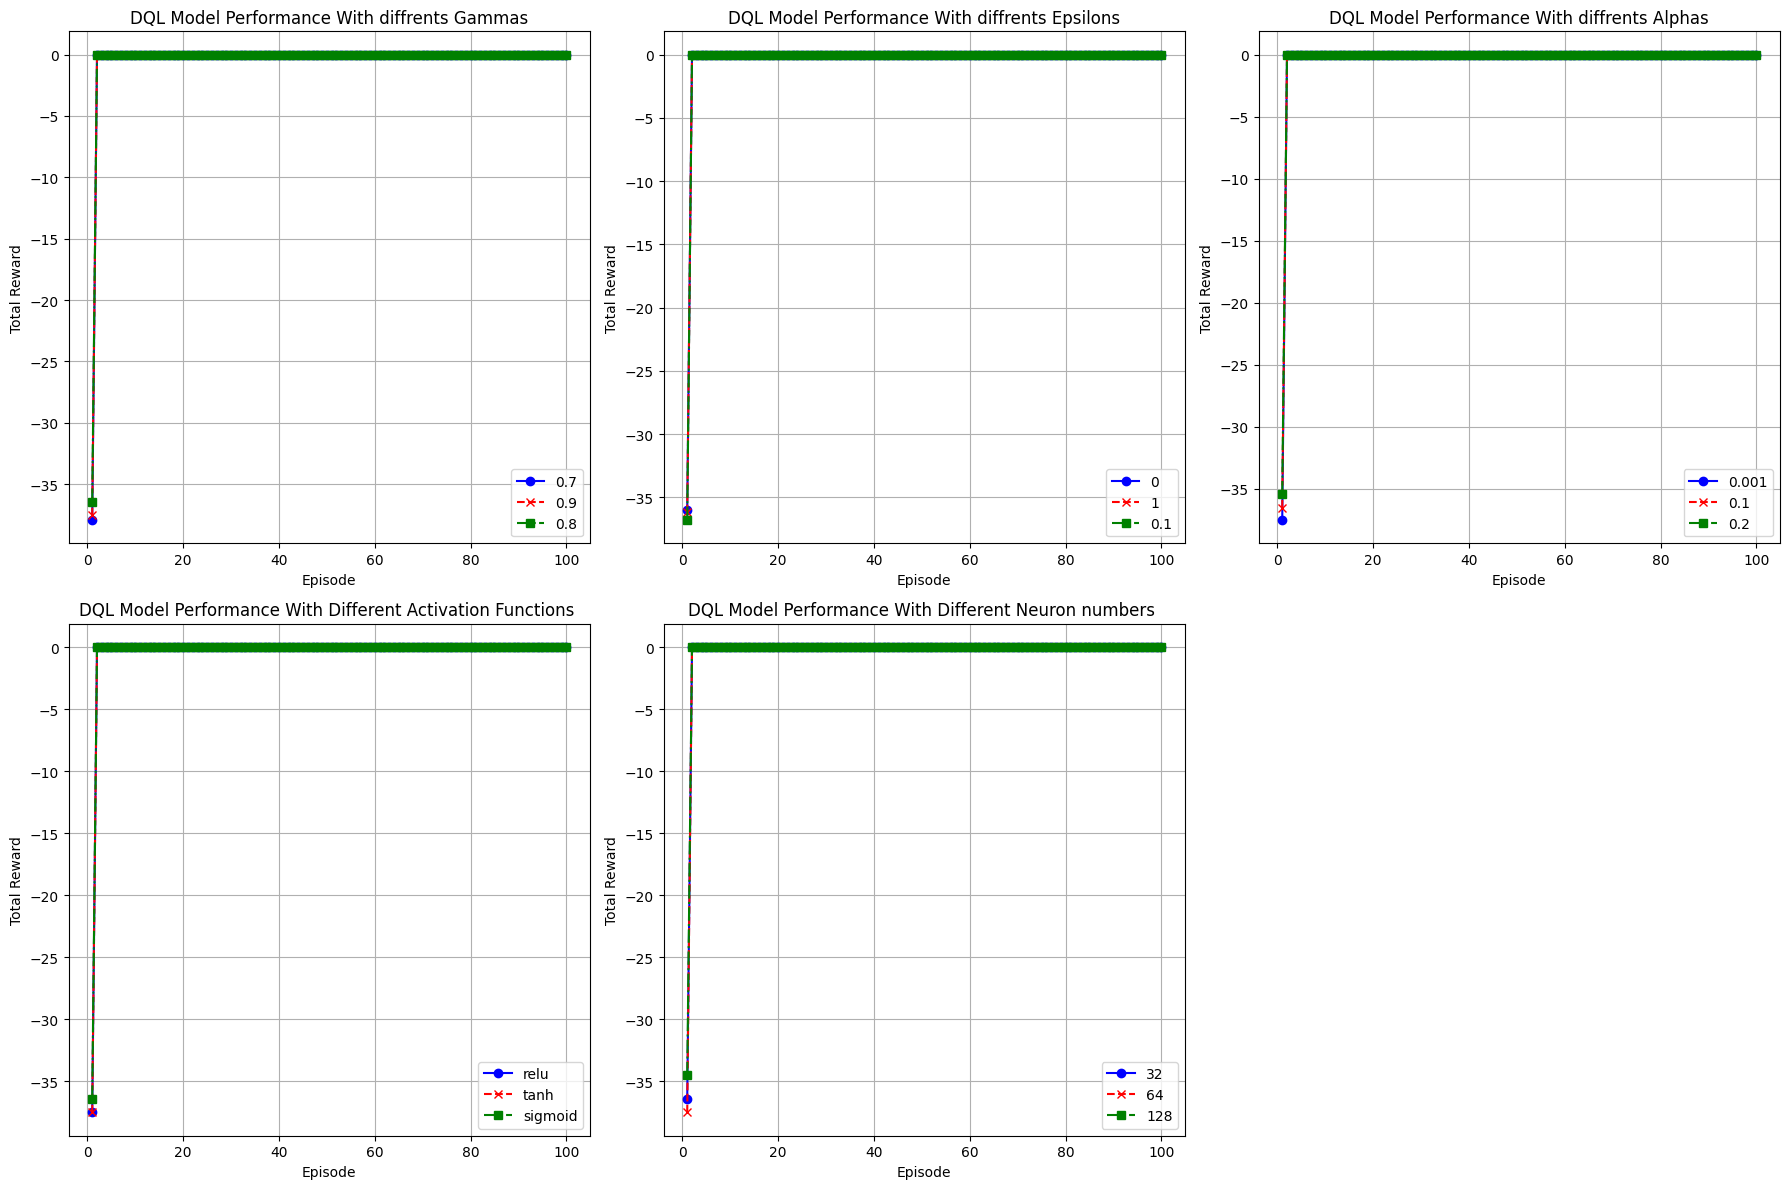

In [27]:
# --- Visualization ---
plt.figure(figsize=(18, 12))  # Adjust the figure size


# Plot 1: Diffrent Gammas
plt.subplot(2, 3, 1)
plt.plot(range(1, NUM_EPISODES + 1), results_gammmas[0][1], label=f"{results_gammmas[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_gammmas[1][1], label=f"{results_gammmas[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_gammmas[2][1], label=f"{results_gammmas[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance With diffrents Gammas")
plt.legend()
plt.grid(True)

# Plot 2: Diffrent Epsilons
plt.subplot(2, 3, 2)  # (rows, cols, position)
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[0][1], label=f"{results_epsilon[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[1][1], label=f"{results_epsilon[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_epsilon[2][1], label=f"{results_epsilon[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance With diffrents Epsilons")
plt.legend()
plt.grid(True)

# Plot 3: Diffrent Alphas
plt.subplot(2, 3, 3)
plt.plot(range(1, NUM_EPISODES + 1), results_alphas[0][1], label=f"{results_alphas[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_alphas[1][1], label=f"{results_alphas[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_alphas[2][1], label=f"{results_alphas[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance With diffrents Alphas")
plt.legend()
plt.grid(True)

# Plot 4: Diffrent Activation Functions
plt.subplot(2, 3, 4)  # (rows, cols, position)
plt.plot(range(1, NUM_EPISODES + 1), results_activations[0][1], label=f"{results_activations[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_activations[1][1], label=f"{results_activations[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_activations[2][1], label=f"{results_activations[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance With Different Activation Functions ")
plt.legend()
plt.grid(True)


# Plot 5: Diffrent Nb_neurons
plt.subplot(2, 3, 5)  # (rows, cols, position)
plt.plot(range(1, NUM_EPISODES + 1), results_neurons[0][1], label=f"{results_neurons[0][0]}", color="blue", linestyle='-', marker="o")
plt.plot(range(1, NUM_EPISODES + 1), results_neurons[1][1], label=f"{results_neurons[1][0]}", color="red", linestyle='--', marker='x')
plt.plot(range(1, NUM_EPISODES + 1), results_neurons[2][1], label=f"{results_neurons[2][0]}", color="green", linestyle='-.', marker='s')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance With Different Neuron numbers ")
plt.legend()
plt.grid(True)

# Show all plots
plt.tight_layout()  # Adjust spacing between plots
plt.show()


**- Best choice : Gamma of 0.8, Epsilon of 0.1, Alpha of 0.2, activation function of sigmoid and nb of neurons of 128**

c:\Users\s_bou\Downloads\Project_RL\Project\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


episode 0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
13.89 0.0
9.26 1.0
4.949583266934691 0.0
5.447456150388656 0.0
1.3792310450226068 0.0
2.146768215422829 0.0
2.336312554689357 0.0
2.519051689864136 0.0
2.8187896205830234 0.0
3.7590117718306524 0.0
3.3307145709040924 0.0
4.041576587424788 0.0
4.386764847903719 0.0
4.534731948196502 0.0
3.715552751794787 0.0
4.524059387798266 0.0
4.8073370981698975 0.0
4.729904648111069 0.0
4.86035927335464 0.0
4.489486350731692 0.0
4.6977091055712155 0.0
5.021860997300188 0.0
5.107794986969525 0.0
4.6015283270871405 0.0
4.80265276002168 0.0
4.328139842028186 0.0
5.1452643405764045 0.0
4.6264639216514 0.0
4.777993998586732 0.0
4.274361716570795 1.0
4.388374468141812 0.0
3.0128219167668457 0.0
3.7114323215254044 0.0
3.3001297337385425 0.0
3.8693999082926496 0.0
4.0481760710787915 0.0
4.149046288753704 0.0
3.8404572057304502 0.0
3.8943053660643563 0.0
4.057836582129997 0.0
4.250962359807093 0.0
4.

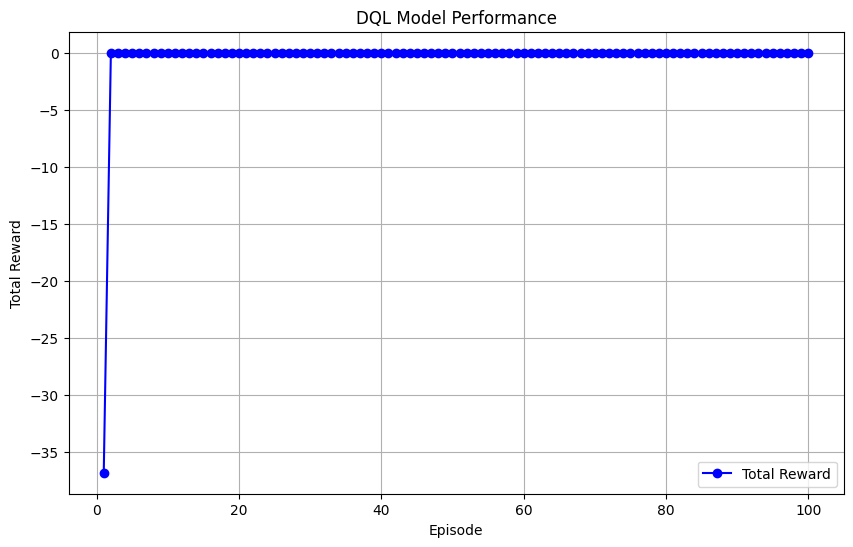

In [28]:
result = train(EPSILON=0.1, GAMMA=0.8, ALPHA=0.2, NB_NEURONS=128, ACTIVATION="sigmoid")
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), result, label="Total Reward", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQL Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### **2 - Testing DQ_Learning:**

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("q_network_model.keras")

# Connect to SUMO
try:
    traci.start(["sumo", "-c", r"sumo_config\simulation.sumocfg"])

    # Initialize the test data list
    test_data = []

    # Testing loop
    while traci.simulation.getMinExpectedNumber() > 0:
        state = [
                traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
                traci.edge.getLastStepHaltingNumber("E4"), 
                traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0
                traci.edge.getWaitingTime("E4"),            # Waiting time in E4
                traci.edge.getWaitingTime("E5"), 
        ]

        # Choose action using the trained model
        q_values = model.predict(np.array(state).reshape(1, -1))[0]
        action = np.argmax(q_values)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("J7", action)

        # Step the simulation
        traci.simulationStep()

        # Get the next state
        next_state = [
                traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
                traci.edge.getLastStepHaltingNumber("E4"), 
                traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0
                traci.edge.getWaitingTime("E4"),            # Waiting time in E4
                traci.edge.getWaitingTime("E5"), 
        ]

        # Calculate the reward (if needed)
        reward = 0  # You can modify this according to your reward function

        # Log relevant information
        test_data.append({
            "state": state,
            "action": action,
            "reward": reward,
            "next_state": next_state
        })

        # Optional: Add a delay to slow down the visualization
        time.sleep(0.1)  # Adjust the delay as needed

except traci.exceptions.FatalTraCIError as e:
    print(f"Error: {e}")

finally:
    # Close connection to SUMO in the finally block
    try:
        traci.close()
    except traci.exceptions.FatalTraCIError:
        pass  # Ignore if there is no active connection

# Save the test data to a file
with open("dql_test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━

### **3 - Visualize_dql:**

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("q_network_model.keras")

# Load the test data
with open("dql_test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

# Connect to SUMO with GUI
try:
    traci.start(["sumo-gui", "-c", r"sumo_config\simulation.sumocfg"])

    # Loop through the test data and apply actions
    for entry in test_data:
        state = entry["state"]

        # Use the trained model to choose an action
        q_values = model.predict(np.array(state).reshape(1, -1))[0]
        action = np.argmax(q_values)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("J7", action)

        # Step the simulation
        traci.simulationStep()

        # Optional: Add a delay to slow down the visualization
        time.sleep(0.1)  # Adjust the delay as needed

except traci.exceptions.FatalTraCIError as e:
    print(f"Error: {e}")

finally:
    # Close connection to SUMO in the finally block
    try:
        traci.close()
    except traci.exceptions.FatalTraCIError:
        pass  # Ignore if there is no active connection

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

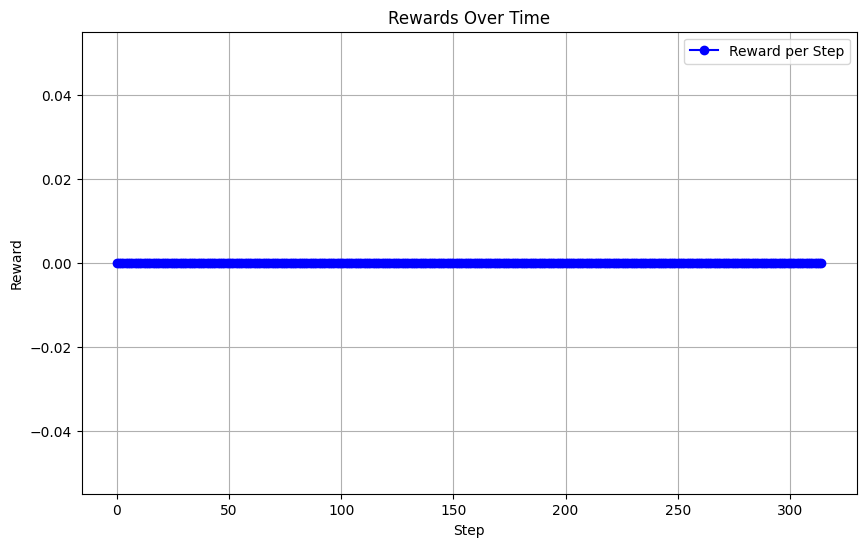

In [ ]:
# Load the test data from the saved file
with open("dql_test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

# Extract the rewards
rewards = [entry["reward"] for entry in test_data]

# Plot the rewards over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label="Reward per Step", color="blue", marker="o")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()
plt.grid(True)
plt.show()